# Relevance Vector Machine with scikit-learn api

## Description

Relevance Vector Machine is kernelised version of ARD Regression and Classification (i.e. it uses the same algorithm for optimization but instead of applying it to raw features applies it to kernelised features).
In RVM each coefficient has zero mean Normal Distribution as its prior, however in contrast to Bayesian Regression coefficients do not share single precision hyperparameter, instead each parameter has its own precision hyperparameter in prior. In the process of learning precision parameters for basis functions with low explanatory power are driven to zero (i.e. variance for some parameters comes close to zero), so after several iterations those parameters can be discarded, since they have zero mean and almost zero variance in prior distribution.

There are three different methods for fitting Relevance Vector Machine, first two of them fixed-point iterations and expectation maximization were proposed by Tipping in his original paper (Tipping(2001)), third one Sequential Sparse Bayesian Learing was discovered later (Faul and Tipping (2003)). 

Version of RVM that used EM and fixed-point iterations was very slow, main problem was that it was starting with all basis functions included in the model and at each iteration was removing basis functions which had low explanatory power. Sparse Bayesian Learing algorithm (that is used in my implementation) starts with single basis function and adds basis functions to the model, this way it only deals with extremely small subset of basis functions, which makes it significantly faster.

## Unit tests for scikit-learn

My implementation passes scikit-learn tests

In [4]:
from sklearn.utils.estimator_checks import check_estimator
from fast_scikit_rvm import RegressionARD,ClassificationARD,RVR,RVC

check_estimator(ClassificationARD)
check_estimator(RVC)
check_estimator(RegressionARD)
check_estimator(RVR)
print "All test are passed ..."

All test are passed ...


## Demonstration Examples: RVR and RVC

### RVR

RVM error on test set is 1.00350143102, number of relevant vectors is 19, time 14.5334789753
SVM error on test set is 1.00786351755, number of support vectors is 4623, time 75.0878829956


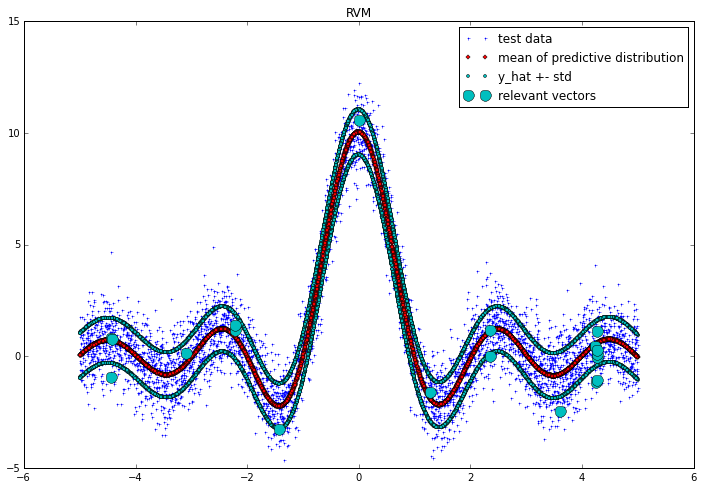

In [12]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
%matplotlib inline

# parameters
n = 10000

# generate data set
np.random.seed(1)
Xc       = np.ones([n,1])
Xc[:,0]  = np.linspace(-5,5,n)
Yc       = 10*np.sinc(Xc[:,0]) + np.random.normal(0,1,n)
X,x,Y,y  = train_test_split(Xc,Yc,test_size = 0.5, random_state = 0)

# train rvr
rvm = RVR(gamma = 1,kernel = 'rbf')
t1 = time.time()
rvm.fit(X,Y)
t2 = time.time()
y_hat,var     = rvm.predict_dist(x)
rvm_err   = mean_squared_error(y_hat,y)
rvs       = np.sum(rvm.active_)
print "RVM error on test set is {0}, number of relevant vectors is {1}, time {2}".format(rvm_err, rvs, t2 - t1)
# train svr
svr = GridSearchCV(SVR(kernel = 'rbf', gamma = 1), param_grid = {'C':[0.001,0.1,1,10,100]},cv = 10)
t1 = time.time()
svr.fit(X,Y)
t2 = time.time()
svm_err = mean_squared_error(svr.predict(x),y)
svs     = svr.best_estimator_.support_vectors_.shape[0]
print "SVM error on test set is {0}, number of support vectors is {1}, time {2}".format(svm_err, svs, t2 - t1)


# plot test vs predicted data
plt.figure(figsize = (12,8))
plt.plot(x[:,0],y,"b+",markersize = 3, label = "test data")
plt.plot(x[:,0],y_hat,"rD", markersize = 3, label = "mean of predictive distribution")
# plot one standard deviation bounds
plt.plot(x[:,0],y_hat + np.sqrt(var),"co", markersize = 3, label = "y_hat +- std")
plt.plot(x[:,0],y_hat - np.sqrt(var),"co", markersize = 3)
plt.plot(rvm.relevant_vectors_,Y[rvm.active_],"co",markersize = 11,  label = "relevant vectors")
plt.legend()
plt.title("RVM")
plt.show()

### RVC Binary Classification

RVM misclassification rate on test set is 0.12, with 5 relevant vectors, time 1.47255587578 

SVM misclassification rate on test set is 0.11,with 119 support vectors, time 0.798488855362 



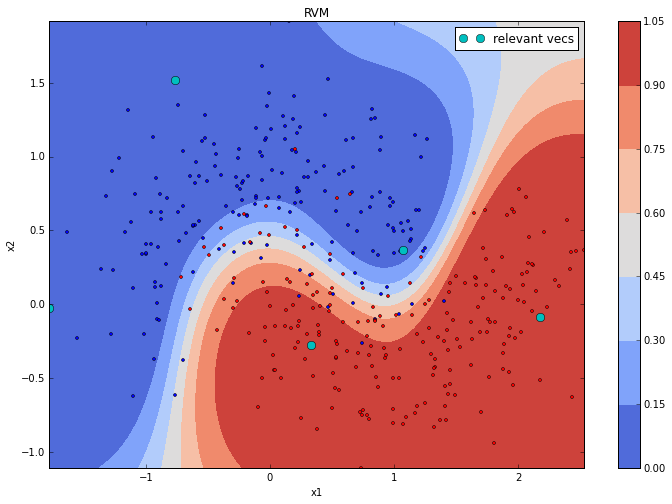

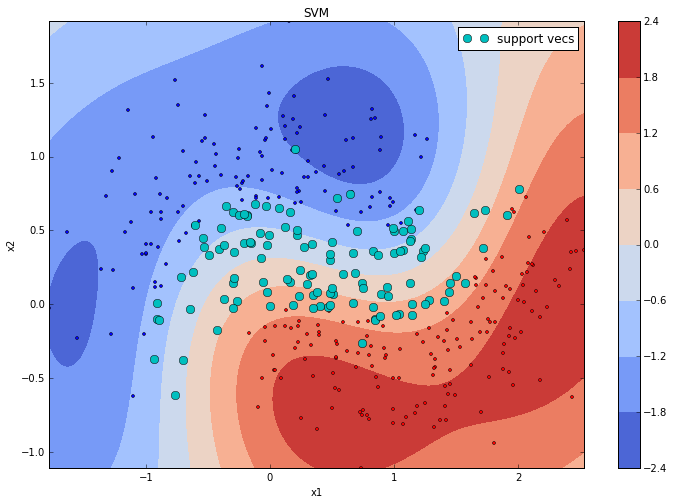

In [32]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC

# Parameters
n = 500
test_proportion = 0.2

# create dataset & split into train/test parts
Xx,Yy   = make_moons(n_samples = n, noise = 0.3, random_state = 1)
X,x,Y,y = train_test_split(Xx,Yy,test_size = test_proportion, 
                                 random_state = 2)

# train rvm with fixed-point optimization
rvm = RVC(kernel = 'rbf', gamma = 1)
t1 = time.time()
rvm.fit(X,Y)
t2 = time.time()
rvm_time = t2 - t1


# train svm (and find best parameters through cross-validation)
svc = GridSearchCV(SVC(), param_grid = {"C":np.logspace(-3,3,9)}, cv = 10)
t1 = time.time()
svc.fit(X,Y)
t2 = time.time()
svm_time = t2 - t1

# errors on test set & sparsity
svm_error = np.sum(y!=svc.predict(x)) / (n * test_proportion)
rvm_error = np.sum(y!=rvm.predict(x)) / (n * test_proportion)
svecs = svc.best_estimator_.support_vectors_.shape[0]
rvecs = np.sum(rvm.active_[0]==True)
rvm_message = "RVM misclassification rate on test set is {0}, with {1} relevant vectors, time {2} \n"
svm_message = "SVM misclassification rate on test set is {0},with {1} support vectors, time {2} \n"
print rvm_message.format(rvm_error, rvecs,rvm_time)
print svm_message.format(svm_error, svecs,svm_time)


# create grid
n_grid = 1000
max_x      = np.max(X,axis = 0)
min_x      = np.min(X,axis = 0)
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
x1,x2      = np.meshgrid(X1,X2)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(x2,(n_grid**2,))

sv_grid = svc.decision_function(Xgrid)
rv_grid = rvm.predict_proba(Xgrid)[:,1]
models  = [rv_grid,sv_grid]
model_names = ["RVM","SVM"]

for model, model_name in zip(models, model_names):
    plt.figure(figsize = (12,8))
    plt.contourf(X1,X2,np.reshape(model,(n_grid,n_grid)),
                       cmap="coolwarm",
                       figsize = (10,16))
    plt.colorbar()
    plt.plot(X[Y==0,0],X[Y==0,1],"bo", markersize = 3)
    plt.plot(X[Y==1,0],X[Y==1,1],"ro", markersize = 3)
    # plot 'support' or 'relevant' vectors
    svrv = None
    point_label = None
    if model_name == "SVM":
        svrv = svc.best_estimator_.support_vectors_
        point_label = "support vecs"
    else:
        svrv = rvm.relevant_vectors_[0]
        point_label = "relevant vecs"
    plt.plot(svrv[:,0],svrv[:,1],'co',markersize=8,label=point_label)
    plt.plot()
    title = model_name
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

### RVC Multiclass (One-Vs-Rest)

RVM misclassification rate 0.0166666666667
SVM misclassification rate 0.0833333333333


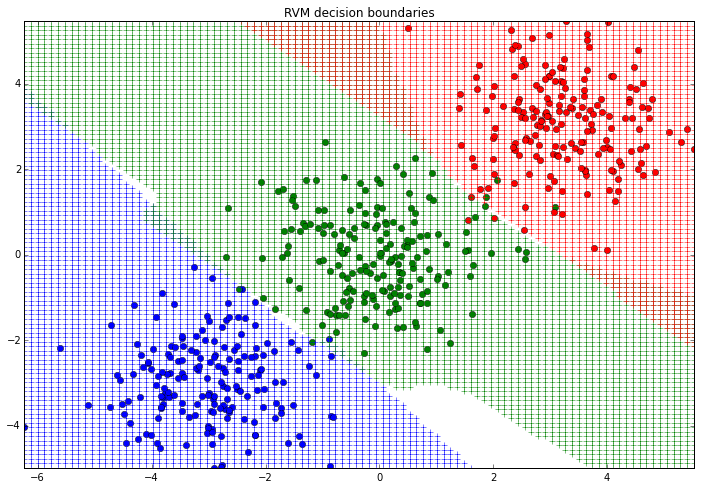

In [88]:
from sklearn.datasets import make_blobs
centers = [(-3, -3), (0, 0), (3, 3)]
n_samples = 600

X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)
X, x, Y, y = train_test_split(X, y, test_size=0.1, random_state=42)
rvm = RVC(gamma = 1, kernel = 'sigmoid')
rvm.fit(X,Y)
svc = GridSearchCV(SVC(kernel = 'sigmoid', degree = 2), 
                   param_grid = {"C":np.logspace(-3,3,7),
                                 "gamma":[0.1,1,10]},
                   cv = 10)
svc.fit(X,Y)

rvc_err = float(np.sum(y!=rvm.predict(x))) / x.shape[0]
svc_err = float(np.sum(y!=svc.predict(x))) / x.shape[0]


# create grid
n_grid = 100
max_x      = np.max(X,axis = 0)
min_x      = np.min(X,axis = 0)
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
x1,x2      = np.meshgrid(X1,X2)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(x2,(n_grid**2,))


rv_grid = rvm.decision_function(Xgrid)
errs        = [rvc_err,svc_err]
colors = ['b+','g+','c+']

print "RVM misclassification rate {0}".format(rvc_err)
print "SVM misclassification rate {0}".format(svc_err)

plt.figure(figsize = (12,8))
plt.xlim(min_x[0],max_x[0])
plt.ylim(min_x[1],max_x[1])
plt.plot(X[Y==0,0],X[Y==0,1],'bo')
plt.plot(X[Y==1,0],X[Y==1,1],'go')
plt.plot(X[Y==2,0],X[Y==2,1],'ro')
colors = ['b+','g+','r+']
for i in range(rv_grid.shape[1]):
    plt.plot(Xgrid[rv_grid[:,i]>0,0],Xgrid[rv_grid[:,i]>0,1],colors[i])
plt.title('RVM decision boundaries')
plt.show()



## SVM vs RVM on real data sets

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import scale


def _compare(X,Y,kernel, gamma, degree, test_size,
             cost, coef0, learn_type = 'regression'):
    '''
    Compares perfomance of RVR and SVR
    
    #TODO: use timeit for timing
    '''
    X,x,Y,y = train_test_split(X,Y,test_size = test_size)
    if learn_type == 'regression':
        RVM = RVR(perfect_fit_tol = 1e-5,tol = 1e-3)
        SVM = SVR()
    else:
        RVM = RVC()
        SVM = SVC()
    rvm = GridSearchCV(RVM,param_grid = {"gamma":gamma,'coef0':coef0,'kernel':kernel,
                                         'degree':degree})
    svm = GridSearchCV(SVM,param_grid = {"C":cost,"gamma":gamma,'coef0':coef0,'kernel':kernel,
                                         'degree':degree})
    
    # fit rvm
    t1 = time.time()
    rvm.fit(X,Y)
    t2 = time.time()
    rvm_time = t2 - t1
    y_rvm = rvm.predict(x)
    
    # fit svm
    t1 = time.time()
    svm.fit(X,Y)
    t2 = time.time()
    svm_time = t2 - t1
    y_svm = svm.predict(x)
    
    # calculate error on test set
    if learn_type == 'regression':
        rvm_err = mean_squared_error(y_rvm,y)
        svm_err = mean_squared_error(y_svm,y)
    else:
        rvm_err = float(np.sum(y_rvm!=y)) / y.shape[0]
        svm_err = float(np.sum(y_svm!=y)) / y.shape[0]
    return {'RVM':[rvm_err,rvm_time],
            'SVM':[svm_err,svm_time]}

# Parameters of simulation 


def compare_rvm_svm(X,Y,kernel, gamma, degree = 2,  test_size = 0.2,
                    cost = [0.01,0.1,1,10,100], coef0 = [0.1,1,10],
                    learn_type = 'regression', n_iter=1):
    error_svm,time_svm = [0]*n_iter,[0]*n_iter
    error_rvm,time_rvm = [0]*n_iter,[0]*n_iter
    for i in range(n_iter):
        out = _compare(X,Y,kernel, gamma, degree, test_size,
                      cost,coef0,learn_type = 'regression')
        error_svm[i],time_svm[i] = out["SVM"]
        error_rvm[i],time_rvm[i] = out["RVM"]
    return error_rvm,time_rvm,error_svm,time_svm
        

# import datasets  & scale  

# Boston Housing
from sklearn.datasets import load_boston
boston = load_boston()
Xb,yb  = scale(boston['data']),boston['target']

from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
Xd,yd  = scale(diabetes['data']),diabetes['target']

# comparison
out_boston   =  compare_rvm_svm(Xb,yb,kernel = ['rbf','sigmoid','poly'], 
                                degree = [2,3],gamma = [0.1,1,10], test_size = 0.2,
                                n_iter = 10)
out_diabetes =  compare_rvm_svm(Xd,yd,kernel = ['rbf','sigmoid','poly'], degree = [2,3],
                                gamma = [0.1,1,10], test_size = 0.2, n_iter = 10)

In [121]:
print out_boston[0]
print out_boston[2]

[22.785599698069483]
[22.107963842543217]


In [122]:
print out_diabetes[0]
print out_diabetes[2]

[3353.4889872875092]
[3563.1851181005454]
